In [53]:
import pandas as pd
import pickle
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [54]:
with open(r'C:\Users\0811m\Desktop\DScover\메인프로젝트\노선별_정류장Kmeans정리.pickle', 'rb') as file:
    stn_kmeans = pickle.load(file)

In [55]:
data = stn_kmeans['143']
data

,arsId,seq,dist,bus_cnt,승하차총승객수
0,8161,1,2395.0,6,691.2897
1,8163,2,1978.0,8,263.4273
2,8408,3,1783.0,6,505.6507
3,8165,4,1710.0,6,409.4038
4,8167,5,1862.0,7,728.0111
...,...,...,...,...,...
108,8166,109,1623.0,7,262.1982
109,8409,110,1745.0,6,339.8362
110,8164,111,1941.0,8,134.3173
111,8162,112,2358.0,6,489.2499


In [56]:
data.set_index('arsId', inplace=True)
data.drop('seq', axis =1, inplace=True)
data.dropna(axis=0, inplace=True)
data

,dist,bus_cnt,승하차총승객수
arsId,,,
8161,2395.0,6,691.2897
8163,1978.0,8,263.4273
8408,1783.0,6,505.6507
8165,1710.0,6,409.4038
8167,1862.0,7,728.0111
...,...,...,...
8166,1623.0,7,262.1982
8409,1745.0,6,339.8362
8164,1941.0,8,134.3173


In [57]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data[['dist', 'bus_cnt', '승하차총승객수']] = scaler.fit_transform(data[['dist', 'bus_cnt', '승하차총승객수']])

In [58]:
# K-means 군집화
kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(data[['dist', 'bus_cnt', '승하차총승객수']])

C:\Users\0811m\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


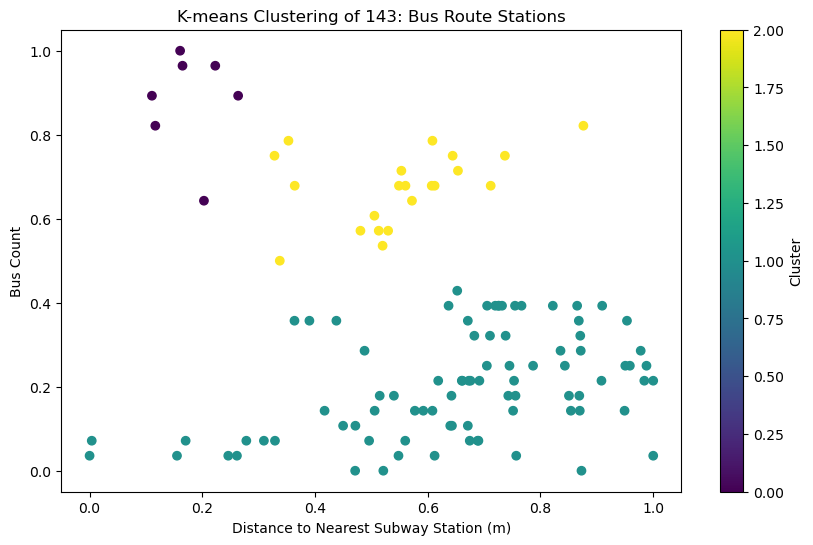

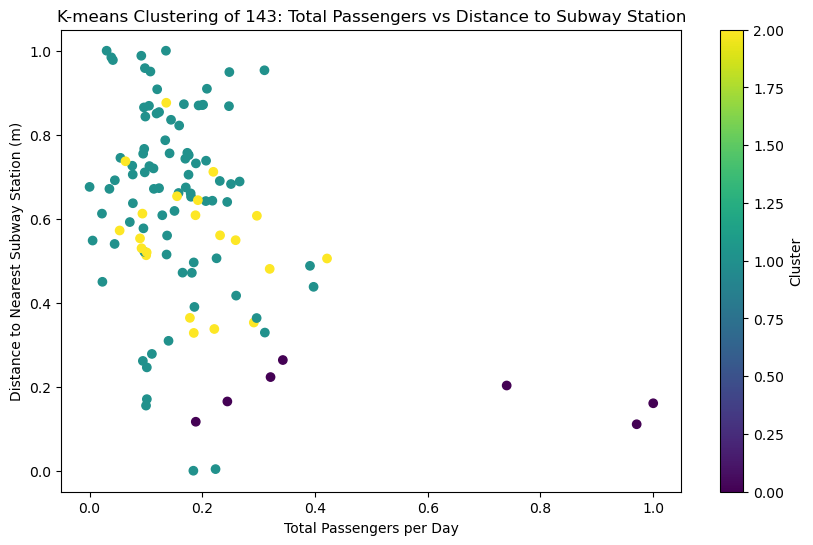

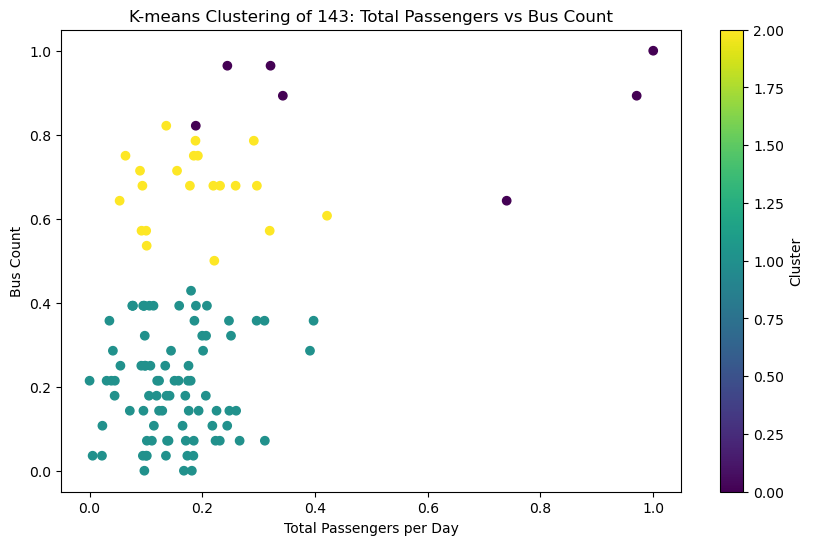

In [59]:
# 군집 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(data['dist'], data['bus_cnt'], c=data['cluster'], cmap='viridis')
plt.xlabel('Distance to Nearest Subway Station (m)')
plt.ylabel('Bus Count')
plt.title('K-means Clustering of 143: Bus Route Stations')
plt.colorbar(label='Cluster')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(data['승하차총승객수'], data['dist'], c=data['cluster'], cmap='viridis')
plt.xlabel('Total Passengers per Day')
plt.ylabel('Distance to Nearest Subway Station (m)')
plt.title('K-means Clustering of 143: Total Passengers vs Distance to Subway Station')
plt.colorbar(label='Cluster')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(data['승하차총승객수'], data['bus_cnt'], c=data['cluster'], cmap='viridis')
plt.xlabel('Total Passengers per Day')
plt.ylabel('Bus Count')
plt.title('K-means Clustering of 143: Total Passengers vs Bus Count')
plt.colorbar(label='Cluster')
plt.show()

급행버스 정류장 선별

In [60]:
# 각 클러스터에 몇 개의 정류장이 있는지 확인
cluster_counts = data['cluster'].value_counts().sort_index()
print("\nNumber of stations in each cluster:\n")
print(cluster_counts)


Number of stations in each cluster:

cluster
0     7
1    85
2    21
Name: count, dtype: int64


In [61]:
#'dist', 'bus_cnt', '승하차총승객수'
# 군집별 특성 확인
print(data.groupby('cluster').mean())

# 군집별 특성 확인 (승객 수, 버스 수, 거리)
cluster_stats = data.groupby('cluster').agg({
    '승하차총승객수': 'mean',
    'bus_cnt': 'mean',
    'dist': 'mean'
})

print(cluster_stats)

# 높은 승객 수, 많은 버스 수, 짧은 거리의 정류장 선택
# 각각의 기준을 표준화(정규화)하여 합산 점수가 가장 높은 군집을 선택
cluster_stats['승객수_정규화'] = (cluster_stats['승하차총승객수'] - cluster_stats['승하차총승객수'].min()) / (cluster_stats['승하차총승객수'].max() - cluster_stats['승하차총승객수'].min())
cluster_stats['버스수_정규화'] = (cluster_stats['bus_cnt'] - cluster_stats['bus_cnt'].min()) / (cluster_stats['bus_cnt'].max() - cluster_stats['bus_cnt'].min())
cluster_stats['dist_정규화'] = (cluster_stats['dist'].max() - cluster_stats['dist']) / (cluster_stats['dist'].max() - cluster_stats['dist'].min())

# 각 기준의 가중합 점수 계산 (가중치는 필요에 따라 조정)
cluster_stats['종합점수'] = cluster_stats['승객수_정규화'] + cluster_stats['버스수_정규화'] + cluster_stats['dist_정규화']

# 종합점수가 가장 높은 군집 선택
selected_cluster = cluster_stats['종합점수'].idxmax()

print(f"Selected cluster: {selected_cluster}")

# 급행 버스 정류장 선택
express_stations = data[data['cluster'] == selected_cluster]

# 급행 버스 정류장 데이터프레임 출력
print(express_stations)


             dist   bus_cnt   승하차총승객수
cluster                              
0        0.177458  0.882653  0.543917
1        0.659226  0.203361  0.148329
2        0.553101  0.673469  0.185174
          승하차총승객수   bus_cnt      dist
cluster                              
0        0.543917  0.882653  0.177458
1        0.148329  0.203361  0.659226
2        0.185174  0.673469  0.553101
Selected cluster: 0
           dist   bus_cnt   승하차총승객수  cluster
arsId                                       
1014   0.222982  0.964286  0.321063        0
2140   0.202905  0.642857  0.740001        0
22020  0.160615  1.000000  1.000000        0
22019  0.110636  0.892857  0.970646        0
2142   0.263563  0.892857  0.342869        0
2139   0.116617  0.821429  0.188415        0
1013   0.164887  0.964286  0.244428        0


In [34]:
data.to_csv(r"C:\Users\0811m\Desktop\DScover\메인프로젝트\stn_kmeans.csv")